In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

from functools import partial

from sklearn.datasets import load_sample_images 


### Convolutional layers

In [23]:
# Loading some sample images
# TensorShape([2, 70, 120, 3]) - 2 images of (70x120) pixels in 3 channels (after cropping...)
images = load_sample_images()["images"]

images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

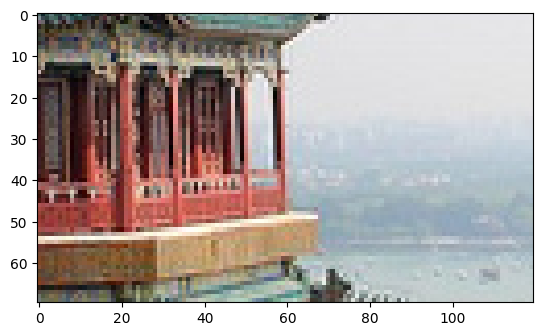

In [24]:
plt.imshow(images[0])

In [26]:
# Applying the images into a conv layer with 32 filters of size (7x7).
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

# The output shape changed. We got 2 images (still). For each one:
# 32 feature maps, each of size (64x114)
fmaps.shape

TensorShape([2, 64, 114, 32])

In [27]:
# Default padding option is "valid" which means no padding. The filter will only be applied where valid.
# The filter does not go out of bound. This means that if the filter and input sizes don't fit exactly, we'll lose 
# pixels in the feature map size (note that above we lost 6 pixels vertically and horizontally).

# When we set the padding to "same", it'll use zero padding to make sure the size of the feature map is the same 
# as the image
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")
fmaps = conv_layer(images)
fmaps.shape


TensorShape([2, 70, 120, 32])

In [30]:
# If we increase the stride, the output feature map's size cannot equal the input size.
# Here we use padding=same and strides=2 which will cause the size of the output to be halved.
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, strides=2, padding="same")
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [31]:
# To get the weights (the filters themselves)
kernels, biases = conv_layer.get_weights()

# We get 32 filters. Each has 3 channels (since the input has 3 channels, we need each one of our filters to be split into 
# 3, each is its own weight matrix). Each filter is of size (7x7)
print (kernels.shape)

# We have 32 bias terms. Each bias term is added to the result of the convolution before it becomes a pixel in the feature
# map.
print (biases.shape) 

(7, 7, 3, 32)
(32,)


### Pooling Layers

In [34]:
# First, compute the convolution of the images (same as we did above)
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="valid")
fmaps = conv_layer(images)
print ("conv layer output shape: ", fmaps.shape)

# The stride size defaults to the pool size
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)
# We feed it the results of the conv layer
pmaps = max_pool(fmaps)
print ("pool layer output shape: ", pmaps.shape)


conv layer output shape:  (2, 64, 114, 32)
pool layer output shape:  (2, 32, 57, 32)


# CNN Architectures

In [3]:
# Fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

# train, validation and test split
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

X_train.shape

(55000, 28, 28)

In [43]:
# Instead of re-writing these arguments every time we call Conv2D, we use partial to "freeze" them
# (It will get called with these arguments)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", 
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
  tf.keras.layers.Reshape(target_shape=[28,28,1]),

  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28,28,1]),
  tf.keras.layers.MaxPool2D(),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=256),
  tf.keras.layers.MaxPool2D(),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  tf.keras.layers.MaxPool2D(),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
  tf.keras.layers.Dropout(0.5),
  
  tf.keras.layers.Dense(units=64, activation="relu", kernel_initializer="he_normal"),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(units=10, activation="softmax"),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
